## Preprocessing / Modeling

The purpose of this notebook is to pre-process our data for use in an LSTM which takes a very specific input in the form of sequences of data over a large window of time. Then use an LSTM model to forecast prices and try out the model on other stock close prices to see how well it performs.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8049 entries, 0 to 8048
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     8049 non-null   object 
 1   Symbol            8049 non-null   object 
 2   Security Name     8049 non-null   object 
 3   Listing Exchange  8049 non-null   object 
 4   Market Category   8049 non-null   object 
 5   ETF               8049 non-null   object 
 6   Round Lot Size    8049 non-null   float64
 7   Test Issue        8049 non-null   object 
 8   Financial Status  3383 non-null   object 
 9   CQS Symbol        4666 non-null   object 
 10  NASDAQ Symbol     8049 non-null   object 
 11  NextShares        8049 non-null   object 
dtypes: float64(1), object(11)
memory usage: 754.7+ KB
number of stocks: 8049
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------

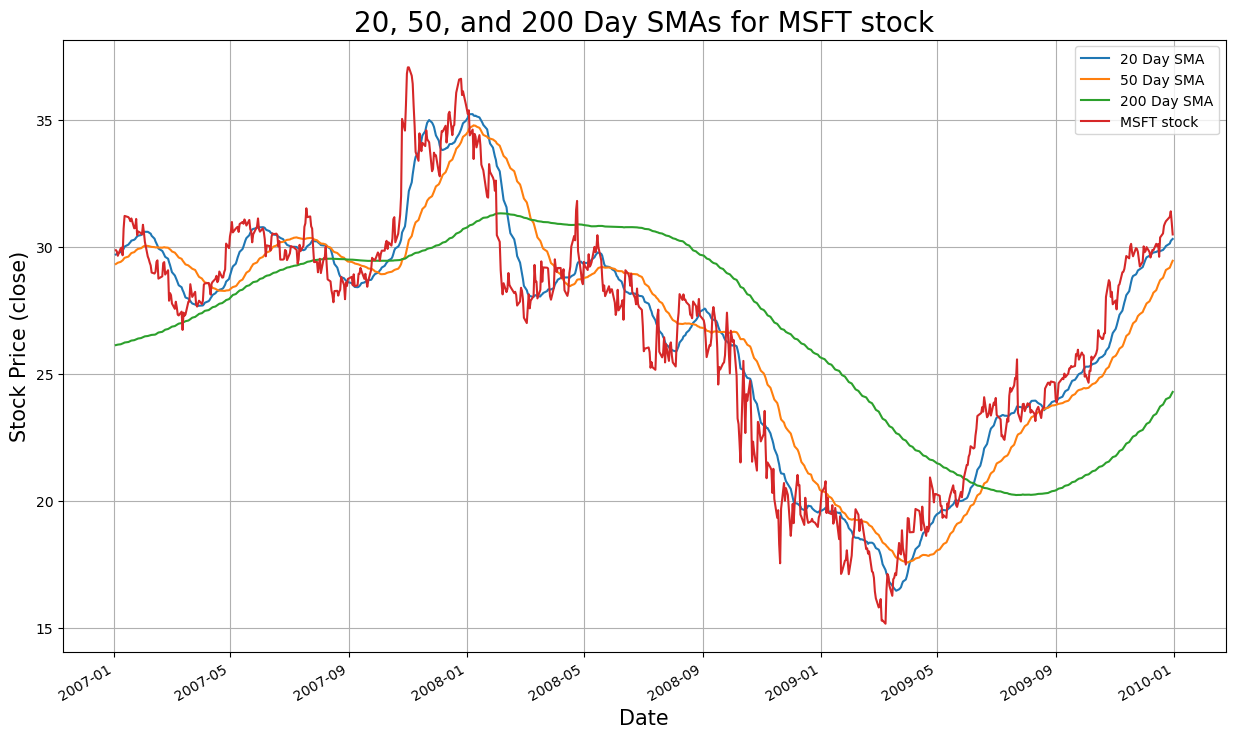

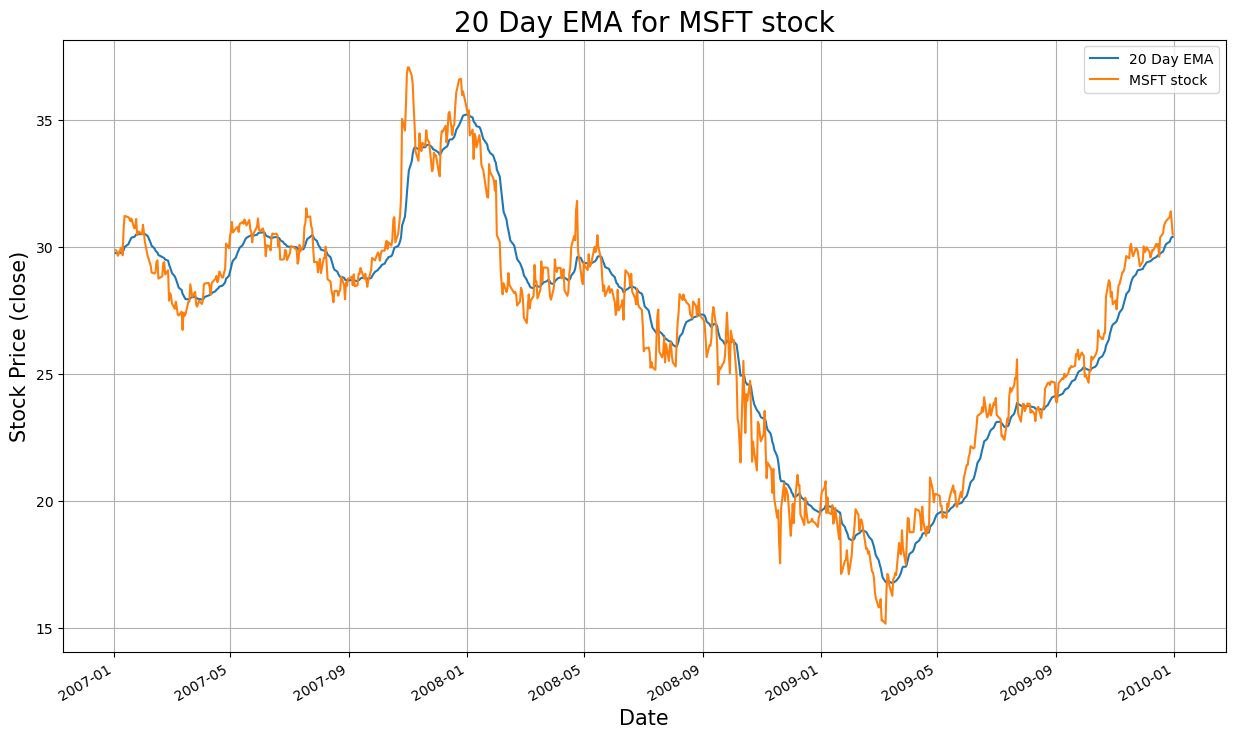

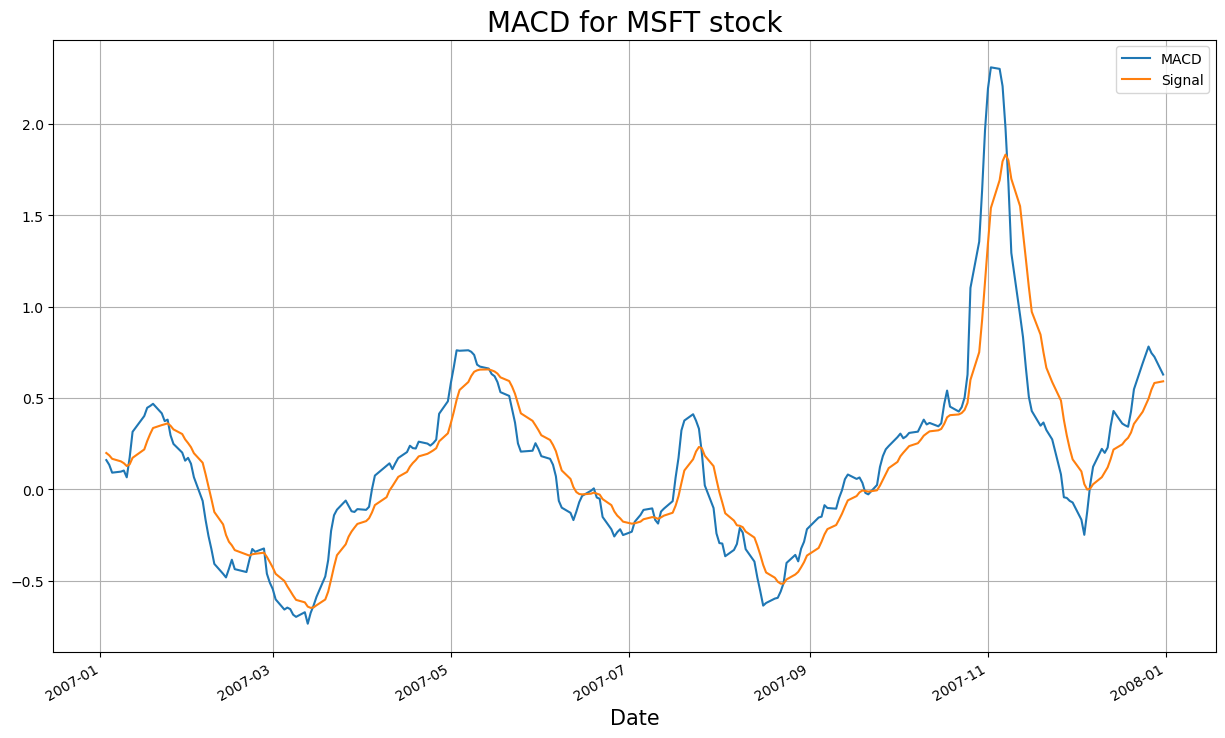

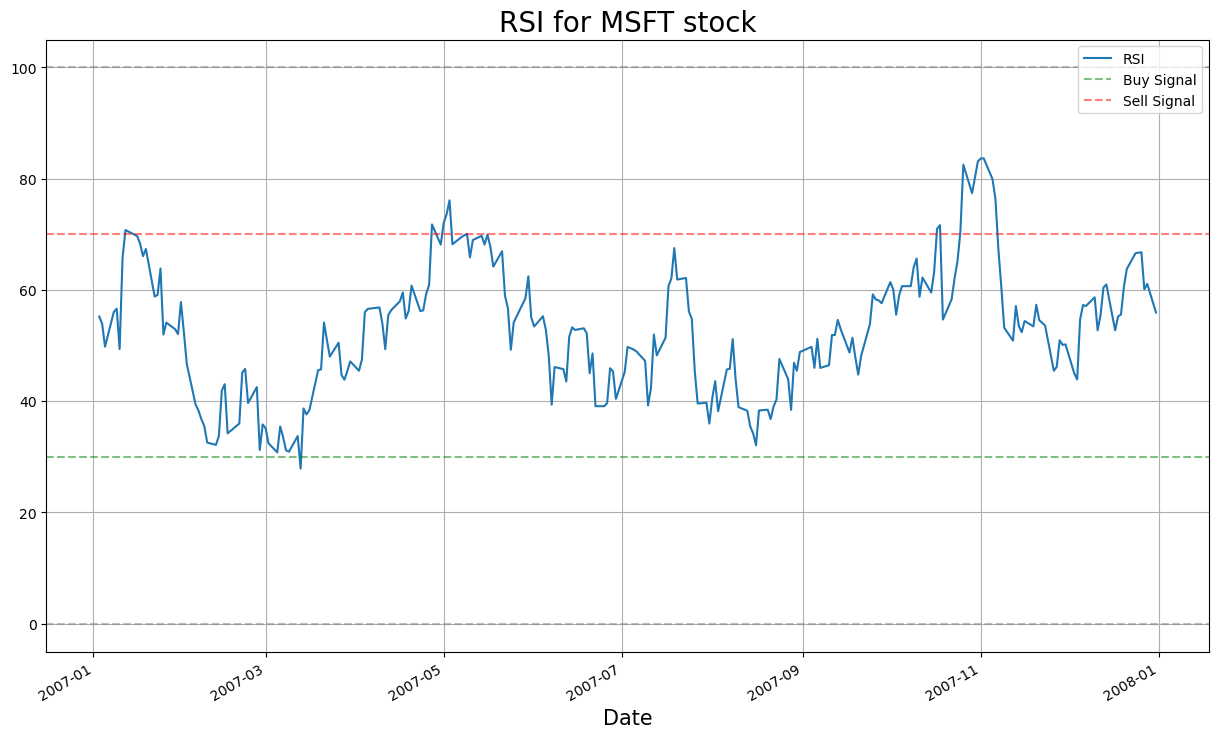

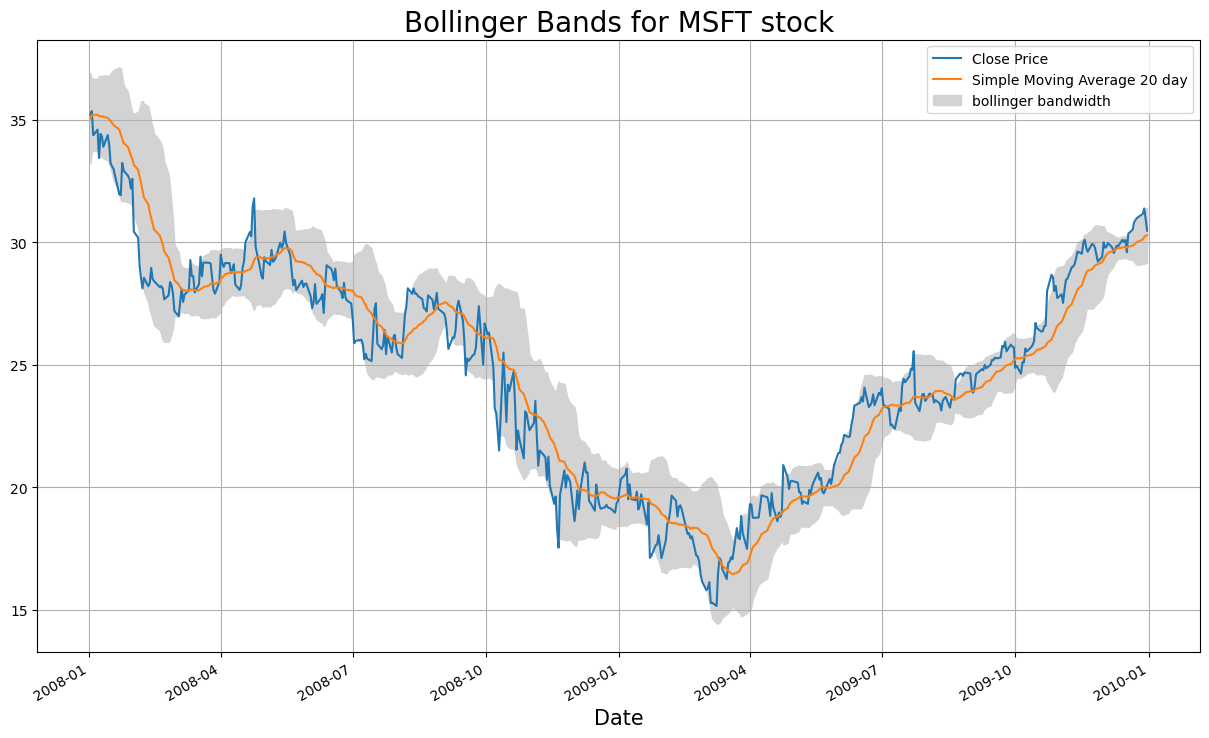

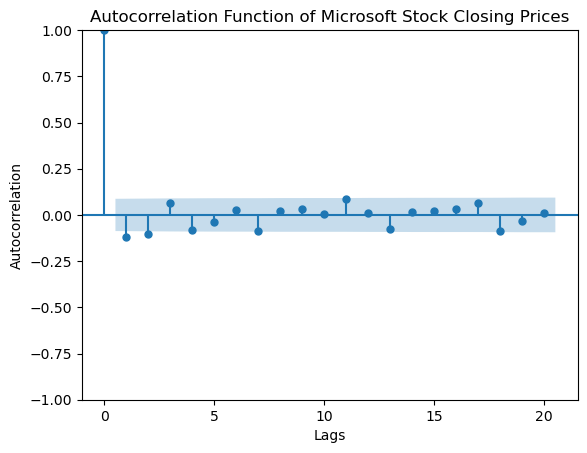

In [1]:
# importing libraries
import time
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#importing from wrangling notebook
from wrangling_EDA import formatter, date_selector

# Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# putting pandas_ta strategy here in case we want to try different metrics
MyStrategy = ta.Strategy(
    name="SMAs, EMAs, rsi, BBs, and MACD",
    ta=[
        {"kind": "sma", "length": 20}, # Simple Moving Average
        {"kind": "sma", "length": 50},
        {"kind": "sma", "length": 200},
        {"kind": "ema", "length": 20},  # Exponential Moving Average
        {"kind": "rsi"}, # Relative Strength Index - indicator of momentum
        {"kind": "bbands", "length": 20, "col_names": ("BBL", "BBM", "BBU", "BBB", "BBP")},
        {"kind": "macd", "fast": 8, "slow": 21, "col_names": ("MACD", "MACD_H", "MACD_S")}
    ]
)

In [3]:
# reading in data

# formatter imports data for specified stock symbol, converts date to datetime object, sets date as index, adds pandas_ta metrics to 
stock = formatter('AAPL')

# isolates specific year range
stock = date_selector(stock,2010,2020)

stock.tail(3)

,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_200,EMA_20,RSI_14,BBL,BBM,BBU,BBB,BBP,MACD,MACD_H,MACD_S
Date,,,,,,,,,,,,,,,,,,,
2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500,274.455997,262.842800,218.11740,276.531866,78.405656,256.774293,274.455997,292.137700,12.884910,0.933895,7.746087,1.268146,6.477940
2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600,275.669496,263.967599,218.64440,277.959306,79.598963,256.838591,275.669496,294.500402,13.661944,0.920864,8.059382,1.265153,6.794229
2019-12-31,289.929993,293.679993,289.519989,293.649994,292.954712,25201400,277.143996,265.112399,219.17255,279.453657,80.999258,257.546231,277.143996,296.741760,14.142659,0.921119,8.397786,1.282846,7.114940


In [4]:
# checking for missing values
stock.isna().sum().any()

False

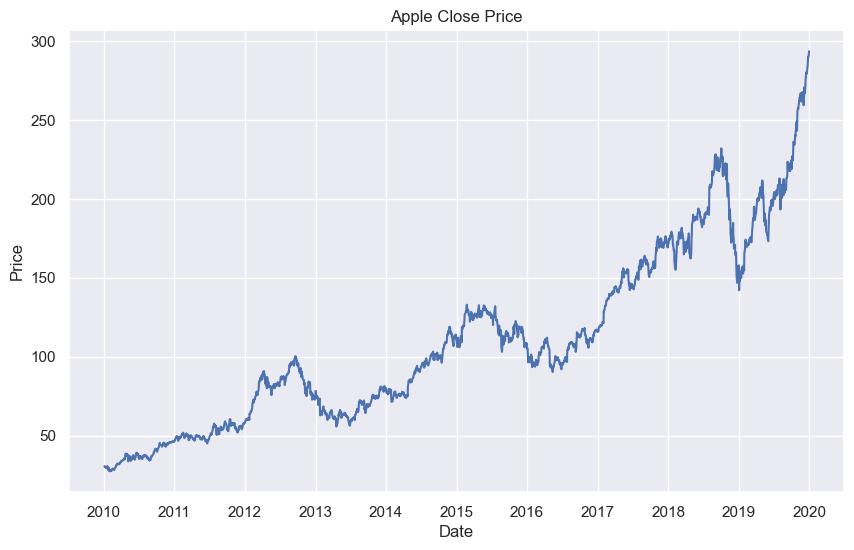

In [5]:
sns.set(style='darkgrid')

plt.figure(figsize=(10,6))
plt.plot(stock['Close'])
plt.title('Apple Close Price')
plt.xlabel('Date')
plt.ylabel('Price')

plt.show()

In [6]:
# scaling and reshaping data
scaler = MinMaxScaler()
close = stock['Close'].values.reshape(-1, 1) # we need to convert shape from (1000, ) to (1000, 1)
close_scaled = scaler.fit_transform(close)

In [7]:
# 120 day window. each sequence contains 120 days worth of data
def train_test_split_seq(df, train_fraction, sequence_length=120):
    #takes the data frame we want sequenced, the size of the sequences, and the fraction of our training data

    # generating sequences
    # obtaining numpy array containing our data split into sequences
    # this is the max number of sequences given the data (we can't have sequences with fewer than 120 days)
    max_sequences = len(df) - sequence_length + 1
    sequences = np.array([df[i:(i+sequence_length)] for i in range(max_sequences)])
    
    print(sequences.shape)
    
    # sequences.shape[0] is just the number of sequences in our array. it is the length of our data frame. This times train frac is how many samples for training
    num_train_samples = int(sequences.shape[0] * train_fraction)

    # notice here that X and Y are just fractions of the same variable. Because we're predicting a future version of itself. 
    # everything up to n_train
    X_train = sequences[:num_train_samples, :-1, :] # X is everything up to the last value of the training section of our sequences
    y_train = sequences[:num_train_samples, -1, :] # y is solely the last value of the training section of our sequences

    # everything after n_train
    X_test = sequences[num_train_samples:, :-1, :] # X is everything up to the last value of the test section of our sequences
    y_test = sequences[num_train_samples:, -1, :] # y is solely the last value of the test section of our sequences 

    # returns same 4 variables as sklearn's train_test_split!
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = train_test_split_seq(close_scaled, 0.7)

(2397, 120, 1)


In [9]:
# the reason that X_train/X_test have an additional dimension compared to y_train/y_test
# is that y contains a single value per sequence
# while x contains seq_len-1 values per sequence
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1677, 119, 1)
X_test shape: (720, 119, 1)
y_train shape: (1677, 1)
y_test shape: (720, 1)


In [10]:
# Now the modeling itself

# at each dropout layer 20% if input will be set to 0 to avoid overfitting
dropout = 0.2
window_size = 119 # this is sequence_length - 1 because the last time step is used as the target for prediction 
# as we saw in the shapes above ^ so 120 - 1

model = Sequential()

model.add(LSTM(window_size, return_sequences=True, input_shape=(window_size, X_train.shape[-1])))
model.add(Dropout(rate=dropout))

model.add(LSTM((window_size * 2), return_sequences=True, activation = 'tanh')) 
model.add(Dropout(rate=dropout))

model.add(LSTM(window_size, return_sequences=False, activation = 'tanh'))
model.add(Dropout(rate=dropout))

model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 119, 119)          57596     
                                                                 
 dropout (Dropout)           (None, 119, 119)          0         
                                                                 
 lstm_1 (LSTM)               (None, 119, 238)          340816    
                                                                 
 dropout_1 (Dropout)         (None, 119, 238)          0         
                                                                 
 lstm_2 (LSTM)               (None, 119)               170408    
                                                                 
 dropout_2 (Dropout)         (None, 119)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [11]:
model.compile(loss='mean_squared_error', optimizer='adam')

start_time = time.time()

history = model.fit(X_train,
                    y_train,
                    epochs=40,
                    batch_size=60,
                    shuffle=False,
                    validation_split=0.2)

elapsed_time = time.time() - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Epoch 1/40
23/23 [==============================] - 11s 392ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 2/40
23/23 [==============================] - 9s 399ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 3/40
23/23 [==============================] - 9s 387ms/step - loss: 0.0058 - val_loss: 0.0019
Epoch 4/40
23/23 [==============================] - 9s 395ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 5/40
23/23 [==============================] - 9s 397ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 6/40
23/23 [==============================] - 9s 394ms/step - loss: 0.0085 - val_loss: 0.0092
Epoch 7/40
23/23 [==============================] - 9s 392ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 8/40
23/23 [==============================] - 9s 404ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 9/40
23/23 [==============================] - 9s 406ms/step - loss: 0.0043 - val_loss: 4.7884e-04
Epoch 10/40
23/23 [==============================] - 9s 406ms/step - loss: 0.0034 - val_loss: 2

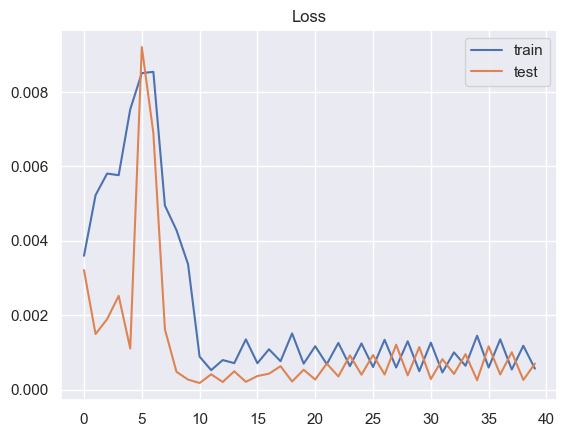

In [12]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()
plt.show()

23/23 [==============================] - 2s 86ms/step


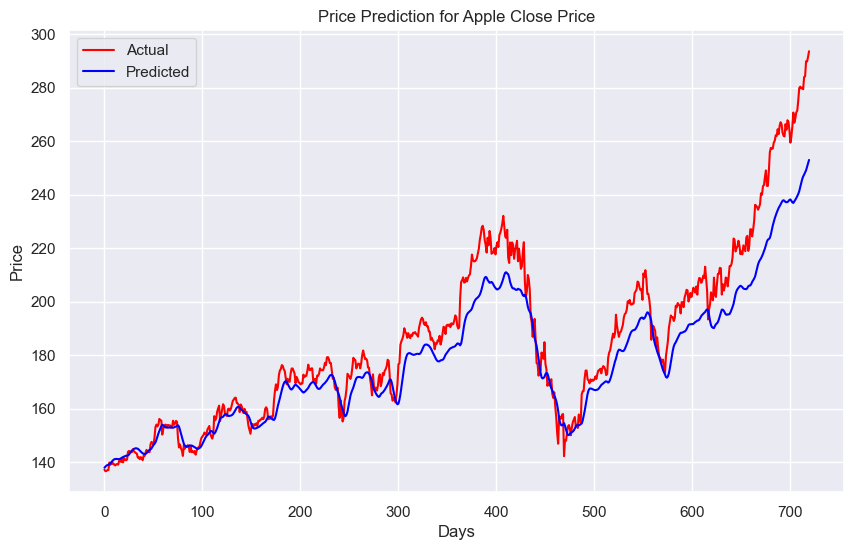

In [13]:
y_pred = model.predict(X_test)

# test and predicted data is transformed so we have to invert them
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

# plotting predicted vs actual
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual', color='red')
plt.plot(y_pred, label='Predicted', color='blue')
plt.title('Price Prediction for Apple Close Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

plt.show()

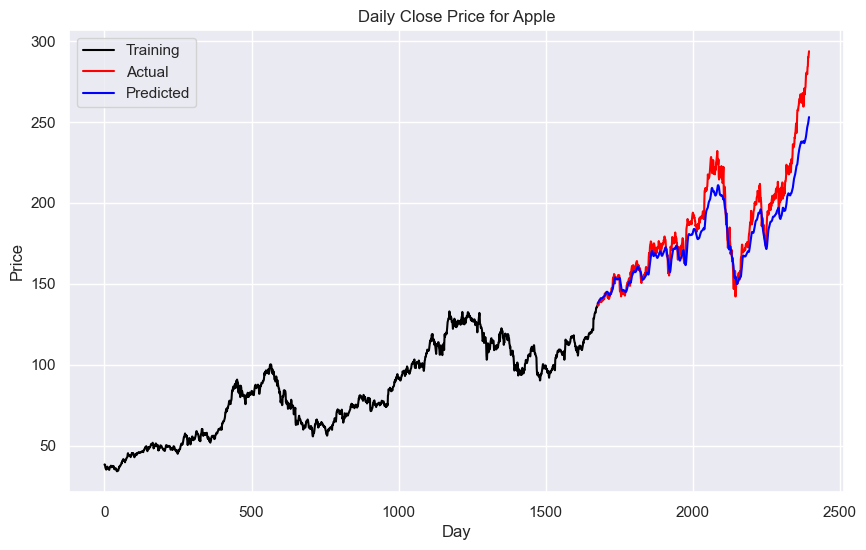

In [14]:
# now to plot with all the data
plt.figure(figsize=(10,6))
# from 0 to len() of training data, it displays the training data
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='black', label='Training')

# then from len() of training data to the end of our predicted/test data it shows the predicted and actual data
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, color='red', label='Actual')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred)), y_pred, color='blue', label='Predicted')
plt.title('Daily Close Price for Apple')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [15]:
# This is pretty good. All models improved significantly when I Increased Sequence Length
# parameters that improved performace:
# train size of 0.7 instead of 0.9
# sequence length of 120 instead of 60 or 90
# date range of 5 years rather than 10.
# number of epochs = 40
# number of batches = 128 rather than 16 or 30

In [16]:
# Trying this model on another stock
def predict_other(stock_symbol):
    new_stock = formatter(stock_symbol)

    # isolates specific year range
    new_stock = date_selector(new_stock,2015,2020)

    new_close_price = new_stock['Close'].values.reshape(-1, 1)

    new_scaled_close = scaler.transform(new_close_price)

    X_train, X_test, y_train, y_test = train_test_split_seq(new_scaled_close, 0.7)

    y_pred = model.predict(X_test)

    # invert the scaler to get the absolute price data
    y_test = scaler.inverse_transform(y_test)
    y_pred = scaler.inverse_transform(y_pred)

    # plots of prediction against actual data for just the prediction range
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(y_test, label='Actual', color='orange')
    plt.plot(y_pred, label='Predicted', color='green')
    plt.title(f'Price Prediction for {stock_symbol}')
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.legend(loc='best')

    # plots entire data range with predictions
    plt.subplot(1,2,2)
    plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='black', label='Training')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, color='red', label='Actual')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred)), y_pred, color='blue', label='Predicted')
    plt.title(f'Price Prediction for {stock_symbol}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    

(1139, 120, 1)
11/11 [==============================] - 1s 86ms/step


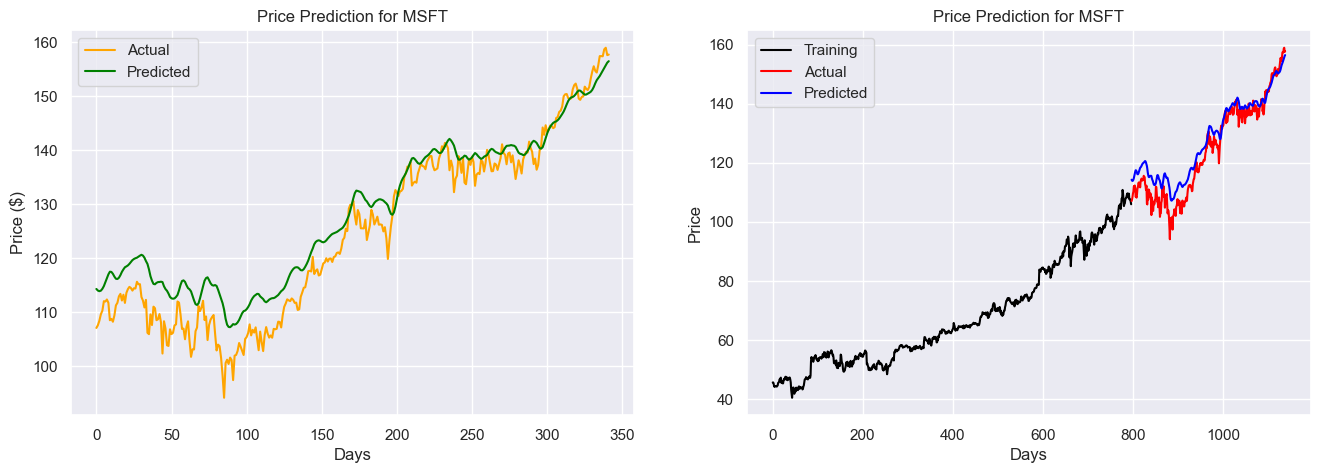

(1139, 120, 1)
11/11 [==============================] - 1s 86ms/step


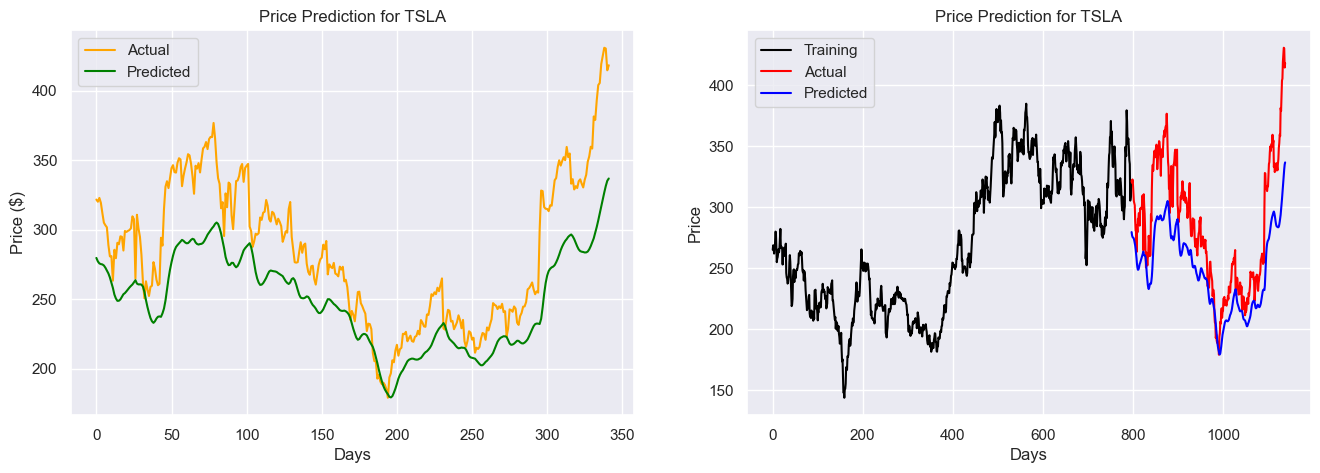

(1139, 120, 1)
11/11 [==============================] - 1s 80ms/step


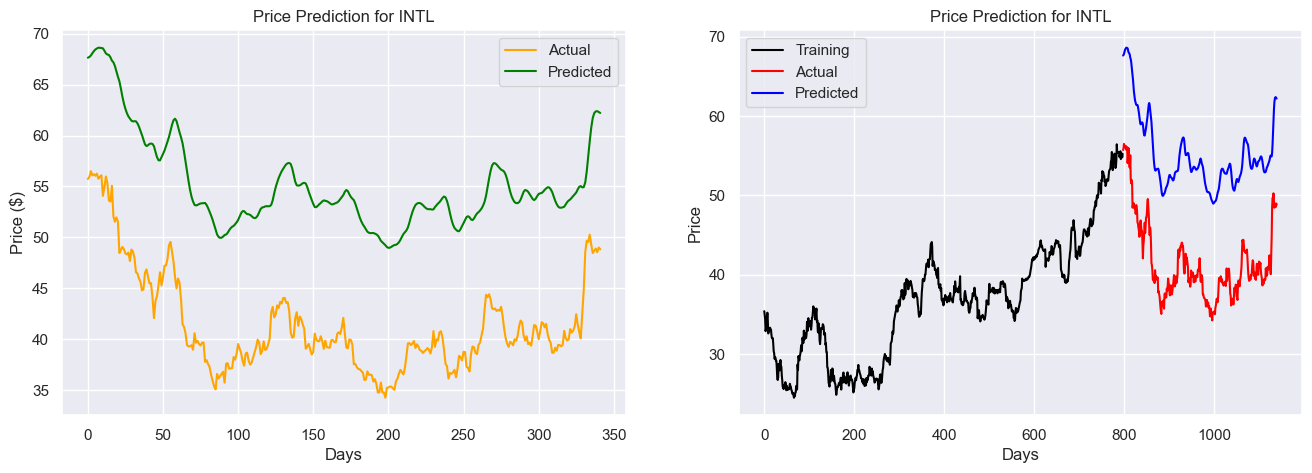

(1139, 120, 1)
11/11 [==============================] - 1s 75ms/step


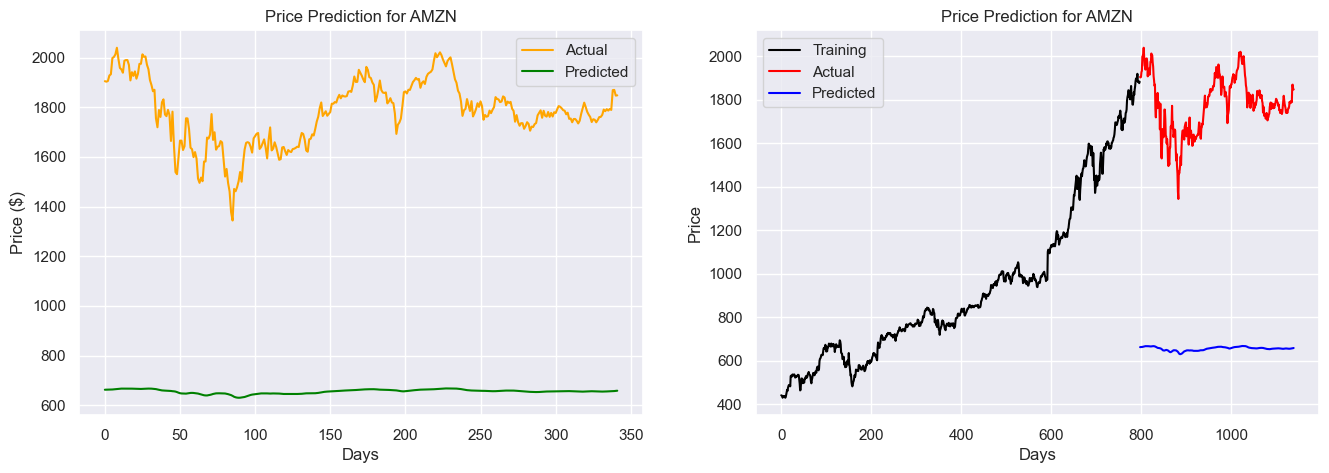

(1139, 120, 1)
11/11 [==============================] - 1s 77ms/step


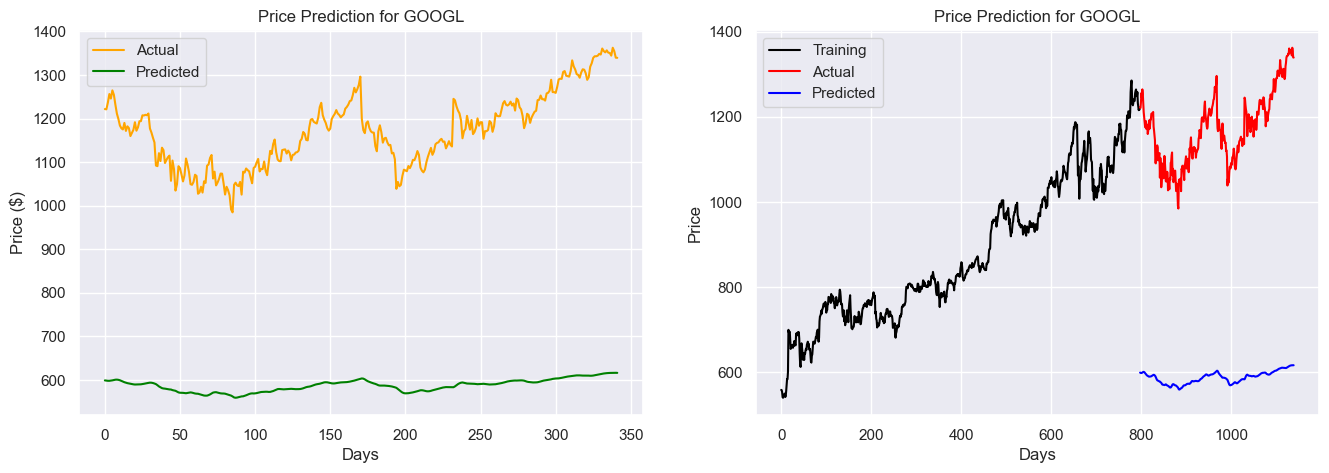

In [17]:
for stock_symbol in ['MSFT','TSLA','INTL','AMZN','GOOGL']:
    predict_other(stock_symbol)

In [18]:
# This seems to predict very poorly for stocks that are much higher or lower in value than our training data.
# Google and Amazon had much higher prices and the model appears to be quite useless
# Intel on the other hand has much lower prices and it over predicts significantly yet captures the shape quite well